# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score



# 1. Get the data

In [2]:
# import train data
df_train = pd.read_csv("data/train.csv")

# import test data
df_test = pd.read_csv("data/test.csv")

# 2. EDA & Data Preparation

## 2.1. Data Analysis

In [243]:
df_train.head()

,ID,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15,ARR_DEL15
0,345355,2020-01-18 22:10:00,2020-01-18 23:59:00,2020-01-18 15:10:00,2020-01-18 15:59:00,SLC,14869,SNA,14908,N128DU,DL,19790,1056,588.0,0,0.0,0
1,323447,2020-01-17 21:47:00,2020-01-18 04:10:00,2020-01-17 16:47:00,2020-01-17 20:10:00,BOS,10721,SEA,14747,N486AS,AS,19930,15,2496.0,0,NaN,0
2,242237,2020-01-13 13:26:00,2020-01-13 14:26:00,2020-01-13 07:26:00,2020-01-13 08:26:00,DAL,11259,HOU,12191,N901WN,WN,19393,3,239.0,0,NaN,0
3,271408,2020-01-15 02:45:00,2020-01-15 03:37:00,2020-01-14 20:45:00,2020-01-14 21:37:00,STL,15016,DSM,11423,N778SW,WN,19393,1588,259.0,0,0.0,0
4,282447,2020-01-15 23:22:00,2020-01-16 00:49:00,2020-01-15 18:22:00,2020-01-15 19:49:00,CLT,11057,CHS,10994,N579NN,OH,20397,5207,168.0,0,NaN,1


In [244]:
df_test.head()

,ID,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,ORIGIN_AIRPORT_ID,DEST,DEST_AIRPORT_ID,TAIL_NUM,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DISTANCE,CANCELLED,DEP_DEL15
0,425552,2020-01-23 01:26:00,2020-01-23 02:52:00,2020-01-22 20:26:00,2020-01-22 21:52:00,LGA,12953,BGR,10581,N8894A,9E,20363,5032,378.0,0,NaN
1,415418,2020-01-23 01:26:00,2020-01-23 03:04:00,2020-01-22 19:26:00,2020-01-22 22:04:00,MDW,13232,PHL,14100,N8615E,WN,19393,1168,668.0,0,NaN
2,414222,2020-01-23 01:26:00,2020-01-23 03:06:00,2020-01-22 18:26:00,2020-01-22 19:06:00,DEN,11292,LAS,12889,N7853B,WN,19393,799,628.0,0,NaN
3,421432,2020-01-23 01:26:00,2020-01-23 02:48:00,2020-01-22 17:26:00,2020-01-22 18:48:00,SJC,14831,SAN,14679,N7812G,WN,19393,4454,417.0,0,0.0
4,421356,2020-01-23 01:26:00,2020-01-23 02:24:00,2020-01-22 17:26:00,2020-01-22 18:24:00,SJC,14831,BUR,10800,N7859B,WN,19393,2024,296.0,0,NaN


In [245]:
df_train.dtypes

ID                         int64
DATE_DEPARTURE_UTC        object
DATE_ARRIVAL_UTC          object
DATE_DEPARTURE_LCL        object
DATE_ARRIVAL_LCL          object
ORIGIN                    object
ORIGIN_AIRPORT_ID          int64
DEST                      object
DEST_AIRPORT_ID            int64
TAIL_NUM                  object
OP_CARRIER                object
OP_CARRIER_AIRLINE_ID      int64
OP_CARRIER_FL_NUM          int64
DISTANCE                 float64
CANCELLED                  int64
DEP_DEL15                float64
ARR_DEL15                  int64
dtype: object

## 2.2. Preparation

### Drop columns

In [3]:
# drop variable 'CANCELLED' in test and train data
columns = ["CANCELLED", "ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID", "OP_CARRIER_AIRLINE_ID"]
df_train_adj = df_train.drop(columns, axis = 1)
df_test_adj = df_test.drop(columns, axis = 1)

## Set index 

In [4]:
df_train_adj = df_train_adj.set_index("ID")
df_test_adj = df_test_adj.set_index("ID")

In [248]:
df_test_adj.shape

(179781, 11)

### Replace DEP_DEL15

In [5]:
# replace for the train data
df_train_adj['Origin_Dest_Carrier'] = df_train_adj['ORIGIN'].str.cat(df_train_adj['DEST'], sep='_').str.cat(df_train_adj['OP_CARRIER'], sep='_')
df_train_adj['DEP_DEL15'] = df_train_adj['DEP_DEL15'].fillna(df_train_adj.groupby('Origin_Dest_Carrier')['DEP_DEL15'].transform("mean"))

In [6]:
# replace for test
df_test_adj['Origin_Dest_Carrier'] = df_test_adj['ORIGIN'].str.cat(df_test_adj['DEST'], sep='_').str.cat(df_test_adj['OP_CARRIER'], sep='_')
df_test_adj['DEP_DEL15'] = df_test_adj['DEP_DEL15'].fillna(df_test_adj.groupby('Origin_Dest_Carrier')['DEP_DEL15'].transform("mean"))

In [7]:
# replace rest with mean
df_train_adj['DEP_DEL15'] = df_train_adj['DEP_DEL15'].fillna(df_train_adj['DEP_DEL15'].mean())
df_test_adj['DEP_DEL15'] = df_test_adj['DEP_DEL15'].fillna(df_train_adj['DEP_DEL15'].mean())

### Replace DISTANCE

In [8]:
df_train_adj['Origin_Dest'] = df_train_adj['ORIGIN'].str.cat(df_train_adj['DEST'], sep='_')
df_train_adj['DISTANCE'] = df_train_adj['DISTANCE'].fillna(df_train_adj.groupby('Origin_Dest')['DISTANCE'].transform('mean'))

In [9]:
df_test_adj['Origin_Dest'] = df_test_adj['ORIGIN'].str.cat(df_test_adj['DEST'], sep='_')
df_test_adj['DISTANCE'] = df_test_adj['DISTANCE'].fillna(df_test_adj.groupby('Origin_Dest')['DISTANCE'].transform('mean'))

In [10]:
df_train_adj['DISTANCE'] = df_train_adj['DISTANCE'].fillna(df_train_adj['DISTANCE'].mean())
df_test_adj['DISTANCE'] = df_test_adj['DISTANCE'].fillna(df_train_adj['DISTANCE'].mean())

### Encode cat variables

In [11]:
# get value mappings
origin_map = df_train_adj['ARR_DEL15'].groupby(df_train_adj['ORIGIN']).mean()
dest_map = df_train_adj['ARR_DEL15'].groupby(df_train_adj['DEST']).mean()

# get airline encoder
import category_encoders as ce
airline_encoder = ce.one_hot.OneHotEncoder(use_cat_names=True).fit(df_train[['OP_CARRIER']])

In [12]:
def transform_categoricals(df, origin_map, dest_map):
    # replace airport IDs by percent delayed
    df['ORIGIN_PCT_DELAY'] = df['ORIGIN'].map(origin_map)
    df['DEST_PCT_DELAY'] = df['DEST'].map(origin_map)
    # transform dtypes
    df[['OP_CARRIER']] = df[['OP_CARRIER']].astype('category')
    # drop redundant columns
    #df = df.drop(columns=['ORIGIN','DEST'])
    # transform airline into dummies
    df_airline_dummys = airline_encoder.transform(df['OP_CARRIER'])
    #df = df.drop(columns=['OP_CARRIER'])
    df = df.merge(df_airline_dummys, how='left', left_index=True, right_index=True)
    
    return df

In [13]:
# transform datasets
df_train_adj = transform_categoricals(df_train_adj, origin_map, dest_map)
df_test_adj = transform_categoricals(df_test_adj, origin_map, dest_map)

In [14]:
# cat variables
cat_vars = ["ORIGIN", "DEST", "OP_CARRIER"]
# set to cat codes
df_train_adj[cat_vars] = df_train_adj[cat_vars].astype('category')
df_test_adj[cat_vars] = df_test_adj[cat_vars].astype('category')

for var in cat_vars:
    df_train_adj[var] = df_train_adj[var].cat.codes
    
for var in cat_vars:
    df_test_adj[var] = df_test_adj[var].cat.codes

In [ ]:
df_test_adj.head()

## 2.3. Feature Engineering - Time

In [15]:
# transform train
df_train_adj['DATE_DEPARTURE_UTC'] = pd.to_datetime(df_train_adj['DATE_DEPARTURE_UTC'])
df_train_adj['DATE_ARRIVAL_UTC'] = pd.to_datetime(df_train_adj['DATE_ARRIVAL_UTC'])
df_train_adj['DATE_DEPARTURE_LCL'] = pd.to_datetime(df_train_adj['DATE_DEPARTURE_LCL'])
df_train_adj['DATE_ARRIVAL_LCL'] = pd.to_datetime(df_train_adj['DATE_ARRIVAL_LCL'])

# test

df_test_adj['DATE_DEPARTURE_UTC'] = pd.to_datetime(df_test_adj['DATE_DEPARTURE_UTC'])
df_test_adj['DATE_ARRIVAL_UTC'] = pd.to_datetime(df_test_adj['DATE_ARRIVAL_UTC'])
df_test_adj['DATE_DEPARTURE_LCL'] = pd.to_datetime(df_test_adj['DATE_DEPARTURE_LCL'])
df_test_adj['DATE_ARRIVAL_LCL'] = pd.to_datetime(df_test_adj['DATE_ARRIVAL_LCL'])



In [16]:
def extract_date_stamps(df, date_cols):
    for col in date_cols:
        df['year_' + col] = df[col].dt.year
        df['month_' + col] = df[col].dt.month
        df['day_' + col] = df[col].dt.day
        df['hour_' + col] = df[col].dt.hour
        df['minute_' + col] = df[col].dt.minute
        df['dayofyear_' + col] = df[col].dt.dayofyear
        df['weekofyear_' + col] = df[col].dt.weekofyear
        df['dayofweek_' + col] = df[col].dt.dayofweek
        df['quarter_' + col] = df[col].dt.quarter
        df['isweekend_' + col] = np.where(df['dayofweek_' + col].isin([5,6]),1,0)
    df['duration_' + col] = (df[date_cols[1]] - df[date_cols[0]]).dt.seconds/60
    return df


In [17]:
date_cols = ['DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL']
df_train_adj = extract_date_stamps(df_train_adj, date_cols)
df_test_adj = extract_date_stamps(df_test_adj, date_cols)

In [18]:
df_test_adj.head()

,DATE_DEPARTURE_UTC,DATE_ARRIVAL_UTC,DATE_DEPARTURE_LCL,DATE_ARRIVAL_LCL,ORIGIN,DEST,TAIL_NUM,OP_CARRIER,OP_CARRIER_FL_NUM,DISTANCE,...,month_DATE_ARRIVAL_LCL,day_DATE_ARRIVAL_LCL,hour_DATE_ARRIVAL_LCL,minute_DATE_ARRIVAL_LCL,dayofyear_DATE_ARRIVAL_LCL,weekofyear_DATE_ARRIVAL_LCL,dayofweek_DATE_ARRIVAL_LCL,quarter_DATE_ARRIVAL_LCL,isweekend_DATE_ARRIVAL_LCL,duration_DATE_ARRIVAL_LCL
ID,,,,,,,,,,,,,,,,,,,,,
425552,2020-01-23 01:26:00,2020-01-23 02:52:00,2020-01-22 20:26:00,2020-01-22 21:52:00,188,32,N8894A,0,5032,378.0,...,1,22,21,52,22,4,2,1,0,86.0
415418,2020-01-23 01:26:00,2020-01-23 03:04:00,2020-01-22 19:26:00,2020-01-22 22:04:00,203,250,N8615E,14,1168,668.0,...,1,22,22,4,22,4,2,1,0,158.0
414222,2020-01-23 01:26:00,2020-01-23 03:06:00,2020-01-22 18:26:00,2020-01-22 19:06:00,88,177,N7853B,14,799,628.0,...,1,22,19,6,22,4,2,1,0,40.0
421432,2020-01-23 01:26:00,2020-01-23 02:48:00,2020-01-22 17:26:00,2020-01-22 18:48:00,306,287,N7812G,14,4454,417.0,...,1,22,18,48,22,4,2,1,0,82.0
421356,2020-01-23 01:26:00,2020-01-23 02:24:00,2020-01-22 17:26:00,2020-01-22 18:24:00,306,53,N7859B,14,2024,296.0,...,1,22,18,24,22,4,2,1,0,58.0


In [19]:
def date_feature_engineering(df, my_cols, date_cols):
    combo_cols = []
    for i in date_cols:
        for j in my_cols:
            combo = j + '_' + i
            combo_cols.append(combo)
    for combo in combo_cols:
        col = combo.split('_')[0]
        df_ = df[['ARR_DEL15', combo]].groupby([combo]).agg(['sum', 'count'])
        df_.columns = ['sum', 'count']
        new_col = 'mean_delay_per_' + combo
        df_[new_col] = df_['sum']/df_['count']
        df_ = df_.drop(['sum', 'count'], axis=1)
        df_ = df_.reset_index()
        df_.rename(columns={col:combo}, inplace=True)
        final = df_.set_index(combo).join(df.set_index(combo))     
    return(final)   

In [20]:
my_cols = ['day', 'hour', 'minute', 'dayofweek', 'isweekend']
df_train_adj = date_feature_engineering(df_train_adj, my_cols, date_cols)

In [ ]:
df_train_adj

In [ ]:
get_my_features = df_train_adj[['mean_delay_per_isweekend_DATE_ARRIVAL_LCL',
       'mean_delay_per_dayofweek_DATE_ARRIVAL_LCL',
       'mean_delay_per_minute_DATE_ARRIVAL_LCL',
       'mean_delay_per_hour_DATE_ARRIVAL_LCL',
       'mean_delay_per_day_DATE_ARRIVAL_LCL',
       'mean_delay_per_isweekend_DATE_DEPARTURE_LCL',
       'mean_delay_per_dayofweek_DATE_DEPARTURE_LCL',
       'mean_delay_per_minute_DATE_DEPARTURE_LCL',
       'mean_delay_per_hour_DATE_DEPARTURE_LCL',
       'mean_delay_per_day_DATE_DEPARTURE_LCL', 
       'year_DATE_DEPARTURE_LCL',
       'month_DATE_DEPARTURE_LCL', 
       'dayofyear_DATE_DEPARTURE_LCL',
       'weekofyear_DATE_DEPARTURE_LCL', 
       'quarter_DATE_DEPARTURE_LCL',
       'year_DATE_ARRIVAL_LCL', 
       'month_DATE_ARRIVAL_LCL',
       'dayofyear_DATE_ARRIVAL_LCL', 
       'weekofyear_DATE_ARRIVAL_LCL',
       'quarter_DATE_ARRIVAL_LCL', 
       'duration_DATE_ARRIVAL_LCL']]

In [ ]:
cols_to_merge_on = ['year_DATE_DEPARTURE_LCL',
       'month_DATE_DEPARTURE_LCL', 
       'dayofyear_DATE_DEPARTURE_LCL',
       'weekofyear_DATE_DEPARTURE_LCL', 
       'quarter_DATE_DEPARTURE_LCL',
       'year_DATE_ARRIVAL_LCL', 
       'month_DATE_ARRIVAL_LCL',
       'dayofyear_DATE_ARRIVAL_LCL', 
       'weekofyear_DATE_ARRIVAL_LCL',
       'quarter_DATE_ARRIVAL_LCL', 
       'duration_DATE_ARRIVAL_LCL']

In [ ]:
df_test_adj = pd.merge(left=get_my_features, right=df_test_adj, left_on=cols_to_merge_on, right_on=cols_to_merge_on)




## 2.4. Select data

In [ ]:
## Deal with imbalanced data set

In [21]:
df_train_balanced_0 = df_train_adj[df_train_adj.ARR_DEL15 == 0].sample(n = df_train_adj[df_train_adj.ARR_DEL15 == 1].shape[0])

In [22]:
df_train_balanced_1 = df_train_adj[df_train_adj.ARR_DEL15 == 1]

In [23]:
df_train_balanced_0.shape

(62195, 54)

In [24]:
df_train_balanced = pd.concat([df_train_balanced_0,df_train_balanced_1], axis=0)
df_train_balanced.shape

(124390, 54)

In [25]:
train_final = df_train_balanced
test_final = df_test_adj

In [26]:
train_final.columns

Index(['mean_delay_per_isweekend_DATE_ARRIVAL_LCL', 'DATE_DEPARTURE_UTC',
       'DATE_ARRIVAL_UTC', 'DATE_DEPARTURE_LCL', 'DATE_ARRIVAL_LCL', 'ORIGIN',
       'DEST', 'TAIL_NUM', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'DISTANCE',
       'DEP_DEL15', 'ARR_DEL15', 'Origin_Dest_Carrier', 'Origin_Dest',
       'ORIGIN_PCT_DELAY', 'DEST_PCT_DELAY', 'OP_CARRIER_DL', 'OP_CARRIER_AS',
       'OP_CARRIER_WN', 'OP_CARRIER_OH', 'OP_CARRIER_AA', 'OP_CARRIER_OO',
       'OP_CARRIER_B6', 'OP_CARRIER_YX', 'OP_CARRIER_EV', 'OP_CARRIER_9E',
       'OP_CARRIER_UA', 'OP_CARRIER_NK', 'OP_CARRIER_MQ', 'OP_CARRIER_YV',
       'OP_CARRIER_F9', 'OP_CARRIER_HA', 'OP_CARRIER_G4',
       'year_DATE_DEPARTURE_LCL', 'month_DATE_DEPARTURE_LCL',
       'day_DATE_DEPARTURE_LCL', 'hour_DATE_DEPARTURE_LCL',
       'minute_DATE_DEPARTURE_LCL', 'dayofyear_DATE_DEPARTURE_LCL',
       'weekofyear_DATE_DEPARTURE_LCL', 'dayofweek_DATE_DEPARTURE_LCL',
       'quarter_DATE_DEPARTURE_LCL', 'isweekend_DATE_DEPARTURE_LCL',
       'y

In [27]:
# select the columns for model building
columns = ["ORIGIN", 
           "DEST", 
           "DISTANCE", 
            "DEP_DEL15",
            'ORIGIN_PCT_DELAY',
             'DEST_PCT_DELAY',
           'day_DATE_DEPARTURE_LCL',
           'hour_DATE_DEPARTURE_LCL', 
           'minute_DATE_DEPARTURE_LCL',
           'dayofyear_DATE_DEPARTURE_LCL',
           'dayofweek_DATE_DEPARTURE_LCL', 
           'isweekend_DATE_DEPARTURE_LCL', 
           'day_DATE_ARRIVAL_LCL',
           'hour_DATE_ARRIVAL_LCL', 
           'minute_DATE_ARRIVAL_LCL',
           'dayofyear_DATE_ARRIVAL_LCL', 
           'dayofweek_DATE_ARRIVAL_LCL',
           'isweekend_DATE_ARRIVAL_LCL',
           'duration_DATE_ARRIVAL_LCL'
             ]
# split in X and y
X, y = train_final[columns], train_final["ARR_DEL15"]
X_test = test_final[columns]

# split in train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

KeyError: "['isweekend_DATE_ARRIVAL_LCL'] not in index"

In [ ]:
X_train.head()

In [ ]:
X_test.head()

# 3. Model selection & training

### Logistic regression

In [ ]:
# normalize data before using Logistic Regression
def normalize_data(X):
    
    normalized_X = (X - np.min(X, axis = 0))/(np.max(X, axis = 0) - np.min(X, axis = 0))
    
    return normalized_X

In [ ]:
# normalize train and val
X_train_norm = normalize_data(X_train)
X_val_norm = normalize_data(X_val)

In [ ]:
# Logistic_regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=43).fit(X_train_norm, y_train)

In [ ]:
# Predictions
logreg_predictions = logreg.predict(X_val)
logreg_probas = logreg.predict_proba(X_val)
logreg.score(X_val, y_val)



### Decision Tree

In [ ]:
# define the classifier
dt = DecisionTreeClassifier(random_state = 43)
dt.fit(X_train, y_train)


In [ ]:
feature_importances = pd.Series(data=dt.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

In [ ]:
# make predictions
# set data and target here
X = X_val
target = y_val

####
dt_predictions = dt.predict(X)
conf_mat = confusion_matrix(y_true=target, y_pred=dt_predictions)
print(conf_mat)

# accurac, precision, recall
accuracy = accuracy_score(target, dt_predictions)
precision = precision_score(target, dt_predictions)
recall = recall_score(target, dt_predictions)

print("Decision Tree Accuracy is: {}".format(accuracy))
print("Decision Tree Precision is: {}".format(precision))
print("Decision Tree Recall is: {}".format(recall))

In [ ]:
from sklearn.metrics import roc_curve

probas = dt.predict_proba(X_val)[:,1]

fpr, tpr, thresholds = roc_curve(y_score = probas, y_true=target)


from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_score=probas, y_true=target)
print(roc_auc)    
    

### SUBMISSION PART

In [ ]:
test_dt_predictions = dt.predict_proba(X_test)[:,1]

ser = pd.Series(test_dt_predictions, index = X_test.index, name = "ARR_DEL15")
print(ser.head())
ser.to_csv("second_submission.csv")

### Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=8, random_state=43).fit(X_train, y_train)

In [ ]:
# make predictions
# set data and target here
X = X_val
target = y_val

####
rf_predictions = rf.predict(X)
conf_mat = confusion_matrix(y_true=target, y_pred=rf_predictions)
print(conf_mat)

probas = rf.predict_proba(X_val)[:,1]

# accurac, precision, recall, roc_auc

accuracy = accuracy_score(target, rf_predictions)
precision = precision_score(target, rf_predictions)
recall = recall_score(target, rf_predictions)
roc_auc = roc_auc_score(y_score=probas, y_true=target)

print("Random Forest ROC_AUC is: {}".format(roc_auc))
print("Random Forest Accuracy is: {}".format(accuracy))
print("Random Forest Precision is: {}".format(precision))
print("Random Forest Recall is: {}".format(recall))

In [229]:
test_rf_predictions = rf.predict_proba(X_test)[:,1]
ser = pd.Series(test_rf_predictions, index = X_test.index, name = "ARR_DEL15")
print(ser.head())
ser.to_csv("fourth_submission.csv")

ID
425552    0.441494
415418    0.379098
414222    0.271873
421432    0.164727
421356    0.233648
Name: ARR_DEL15, dtype: float64


In [233]:
feature_importances = pd.Series(data=rf.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False)

DEP_DEL15                       0.737454
hour_DATE_ARRIVAL_LCL           0.049517
hour_DATE_DEPARTURE_LCL         0.042104
duration_DATE_ARRIVAL_LCL       0.036673
dayofweek_DATE_ARRIVAL_LCL      0.022323
dayofweek_DATE_DEPARTURE_LCL    0.020226
ORIGIN_PCT_DELAY                0.019809
DEST_PCT_DELAY                  0.013586
DISTANCE                        0.012283
dayofyear_DATE_DEPARTURE_LCL    0.007950
day_DATE_ARRIVAL_LCL            0.006303
day_DATE_DEPARTURE_LCL          0.005963
dayofyear_DATE_ARRIVAL_LCL      0.005111
DEST                            0.004170
isweekend_DATE_ARRIVAL_LCL      0.004061
ORIGIN                          0.003963
isweekend_DATE_DEPARTURE_LCL    0.003498
minute_DATE_ARRIVAL_LCL         0.002585
minute_DATE_DEPARTURE_LCL       0.002420
dtype: float64

# 4. Evaluate results

### AUROC

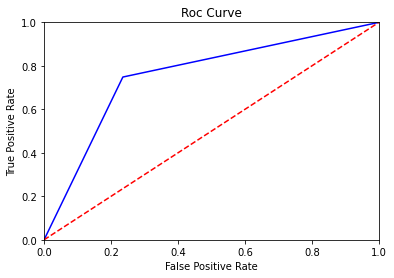

In [240]:
plt.title('Roc Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()